# Obesity Risk Analisys and Prediction

In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(train_df.head())
print(train_df.columns)

   id  Gender        Age    Height      Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998   81.669950                            yes   
1   1  Female  18.000000  1.560000   57.000000                            yes   
2   2  Female  18.000000  1.711460   50.165754                            yes   
3   3  Female  20.952737  1.710730  131.274851                            yes   
4   4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS       WeightCategory  
0  0.976473

In [3]:
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15533 entries, 0 to 15532
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15533 non-null  int64  
 1   Gender                          15533 non-null  object 
 2   Age                             15533 non-null  float64
 3   Height                          15533 non-null  float64
 4   Weight                          15533 non-null  float64
 5   family_history_with_overweight  15533 non-null  object 
 6   FAVC                            15533 non-null  object 
 7   FCVC                            15533 non-null  float64
 8   NCP                             15533 non-null  float64
 9   CAEC                            15533 non-null  object 
 10  SMOKE                           15533 non-null  object 
 11  CH2O                            15533 non-null  float64
 12  SCC                             

## Feature Engineering

In [4]:
# ---------------------------------------------------------------
# STEP 1: Feature Engineering (Do this first)
# ---------------------------------------------------------------
# Create BMI and drop the original columns
for df in [train_df, test_df]:
    # Check for division by zero, although height shouldn't be 0
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Define target and features to drop
target_col = 'WeightCategory'
drop_cols = ['id', 'FCVC', 'FAVC', 'Height', 'Weight'] # Drop originals

numerical_cols = ['Age','BMI','NCP', 'CH2O', 'FAF', 'TUE']

# Define features for One-Hot Encoding (no order)
nominal_cols = ['MTRANS']

# Define features for Binary Encoding (0/1)
# OrdinalEncoder handles this perfectly.
binary_cols = ['Gender', 'family_history_with_overweight', 'SCC', 'SMOKE']
# Define features for Ordinal Encoding (with order)
caec_order = ['no', 'Sometimes', 'Frequently', 'Always']
calc_order = ['no', 'Sometimes', 'Frequently']




## Data Visualization

### Finding Outliers for each Feature

In [5]:

# Calculate the IQR for each numeric column
Q1 = train_df[numerical_cols].quantile(0.25)
Q3 = train_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers for each numeric column
outliers_count = ((train_df[numerical_cols] < lower_bound) | (train_df[numerical_cols] > upper_bound)).sum()

# Display the count of outliers for each column
print("Count of outliers for each column:")
print(outliers_count)

Count of outliers for each column:
Age      792
BMI        0
NCP     4548
CH2O       0
FAF        0
TUE        0
dtype: int64


### distribution of various numeric features in the dataset

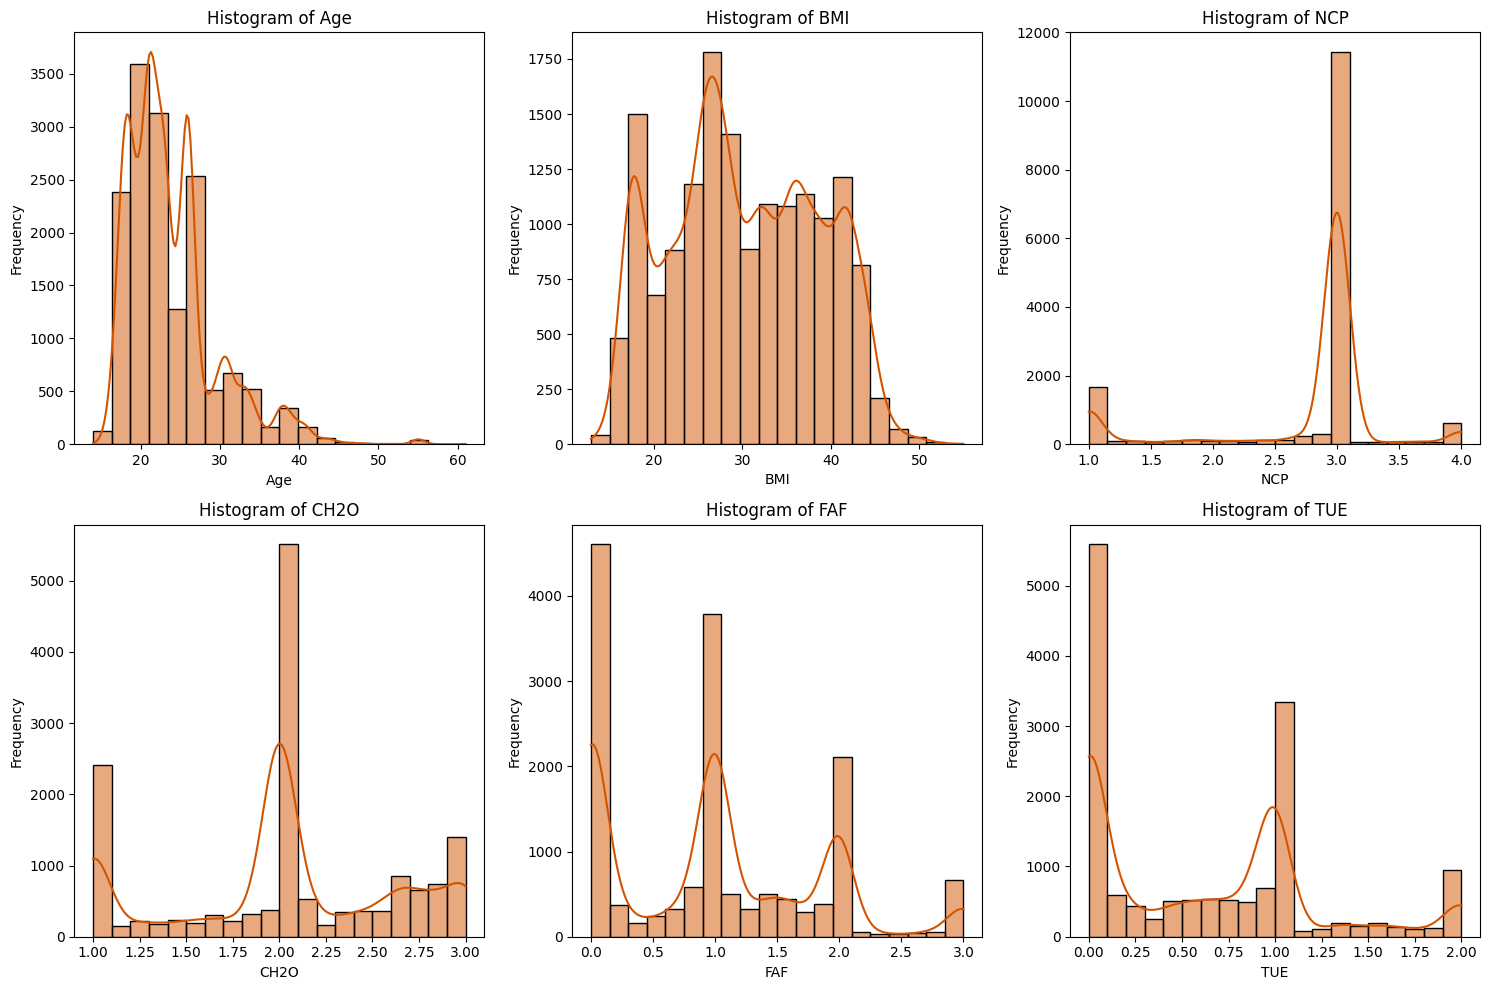

In [6]:
# Create subplots
num_rows = len(numerical_cols) // 3 + (len(numerical_cols) % 3 > 0)
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Create histograms for each numeric column
for i, column in enumerate(numerical_cols):
    sns.histplot(train_df[column], kde=True, color='#D35400', bins=20, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Hide extra subplots
for j in range(len(numerical_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Make a fuction that adds data labels for countplots
def add_data_labels(ax):
    """Add data labels to the bars of a countplot."""
    for p in ax.patches:
        ax.annotate(f"{int(p.get_height())}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

### distribution of the target variable

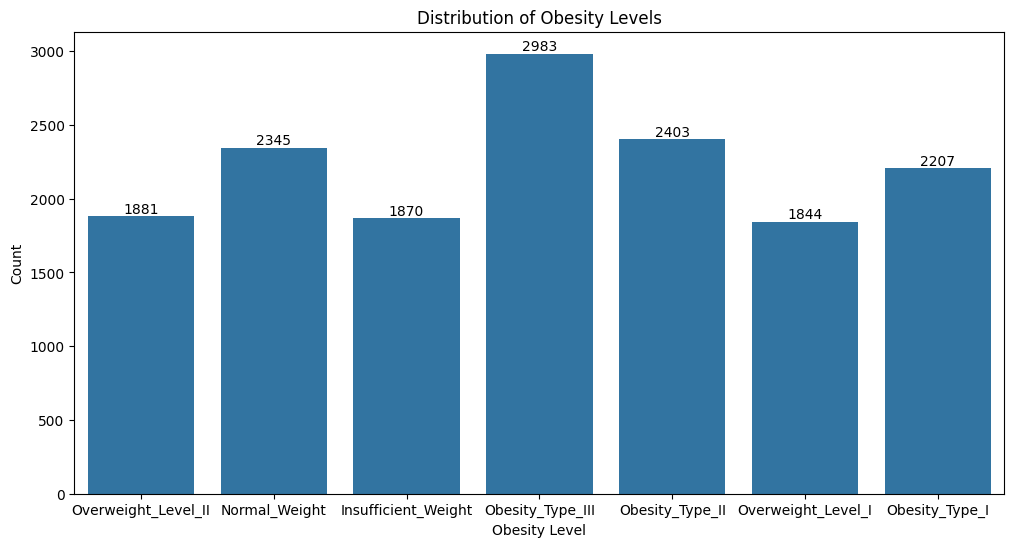

In [8]:
# Visualize the distribution of the target variable
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='WeightCategory', data=train_df)
add_data_labels(ax)
plt.title('Distribution of Obesity Levels')
plt.xlabel('Obesity Level')
plt.ylabel('Count')
plt.show()

### relationship between age and obesity levels

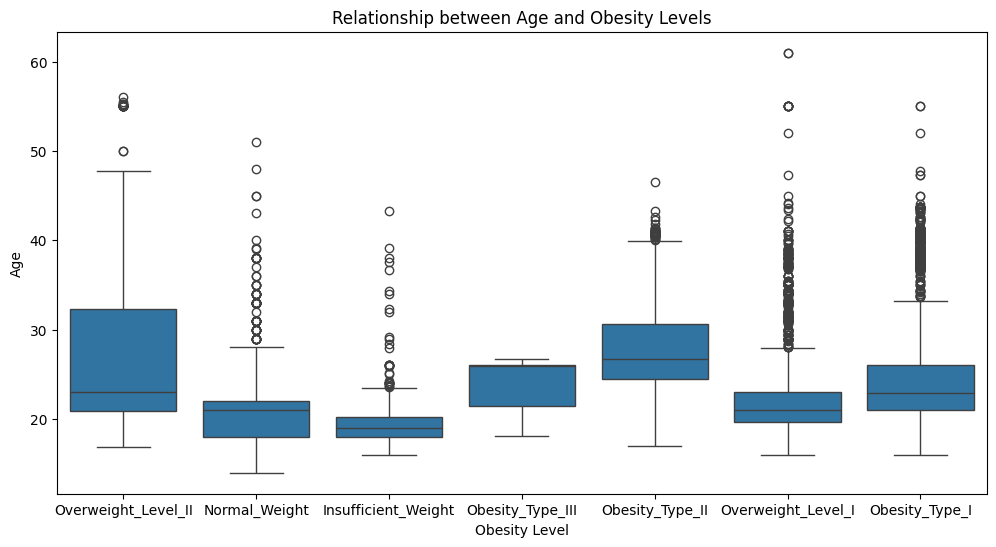

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='WeightCategory', y='Age', data=train_df)
plt.title('Relationship between Age and Obesity Levels')
plt.xlabel('Obesity Level')
plt.ylabel('Age')
plt.show()

### Distribution of Age by Gender

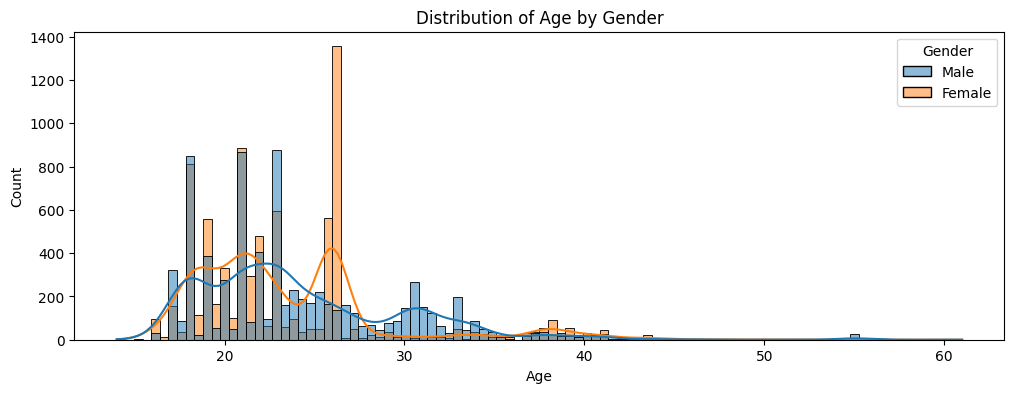

In [10]:
plt.figure(figsize=(12, 4))
sns.histplot(data=train_df, x='Age', hue='Gender', kde=True)
# add_data_labels(ax)
plt.title('Distribution of Age by Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### differences in obesity levels based on family history with overweight

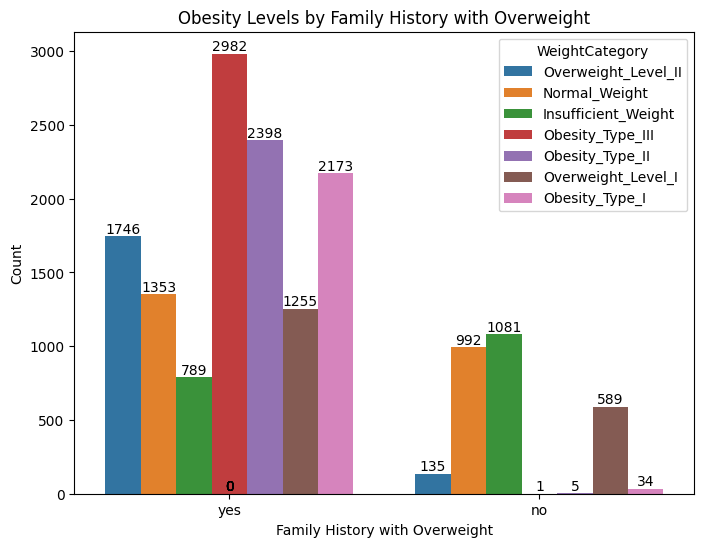

In [11]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='family_history_with_overweight', hue='WeightCategory', data=train_df)
add_data_labels(ax)
plt.title('Obesity Levels by Family History with Overweight')
plt.xlabel('Family History with Overweight')
plt.ylabel('Count')
plt.show()

### Distribution of Weight by Gender

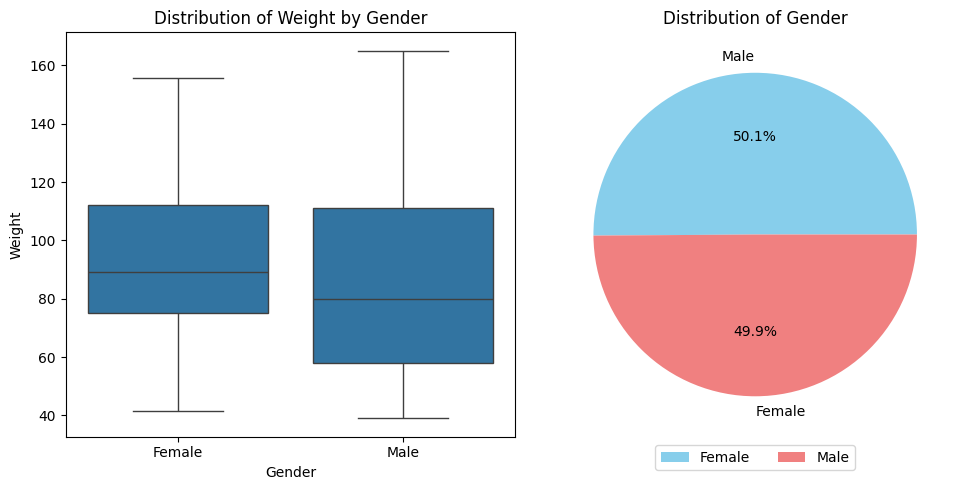

In [12]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Boxplot
sns.boxplot(x='Gender', y='Weight', data=train_df, ax=axes[0])
axes[0].set_title('Distribution of Weight by Gender')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Weight')
axes[0].set_xticks(ticks=[0, 1])
axes[0].set_xticklabels(['Female', 'Male'])

# Plot 2: Pie chart
train_df['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], ax=axes[1])
axes[1].set_title('Distribution of Gender')
axes[1].set_ylabel('')

# Move legend to bottom center with 2 columns
axes[1].legend(labels=['Female', 'Male'], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
plt.show()

### difference in obesity levels based on transportation mode (MTRANS)

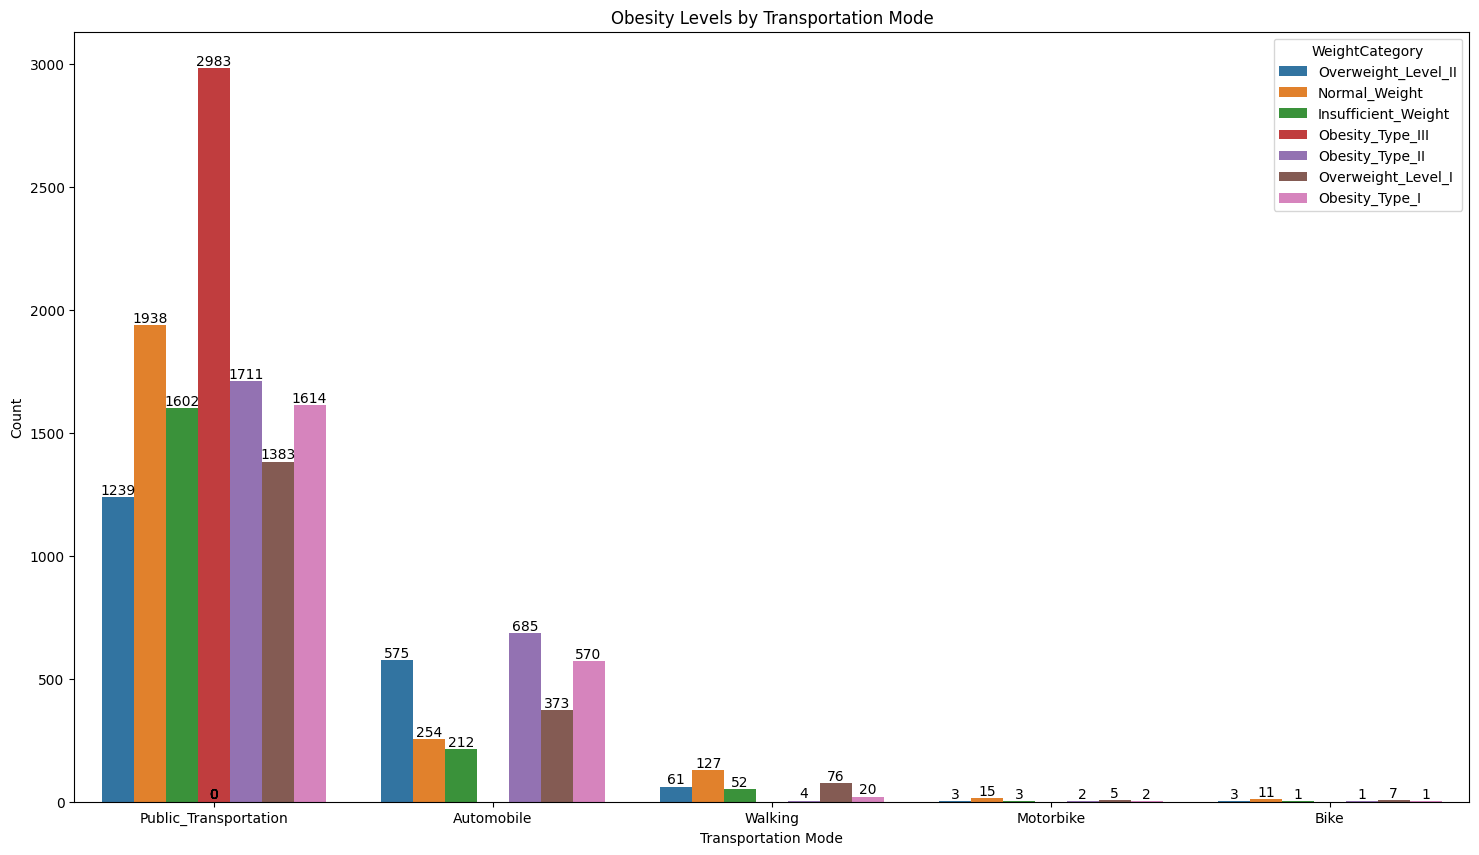

In [13]:
plt.figure(figsize=(18, 10))
ax = sns.countplot(x='MTRANS', hue='WeightCategory', data=train_df)
add_data_labels(ax)
plt.title('Obesity Levels by Transportation Mode')
plt.xlabel('Transportation Mode')
plt.ylabel('Count')
plt.show()

### differences in weight distribution between individuals who frequently consume high-caloric food (FAVC) and those who do not

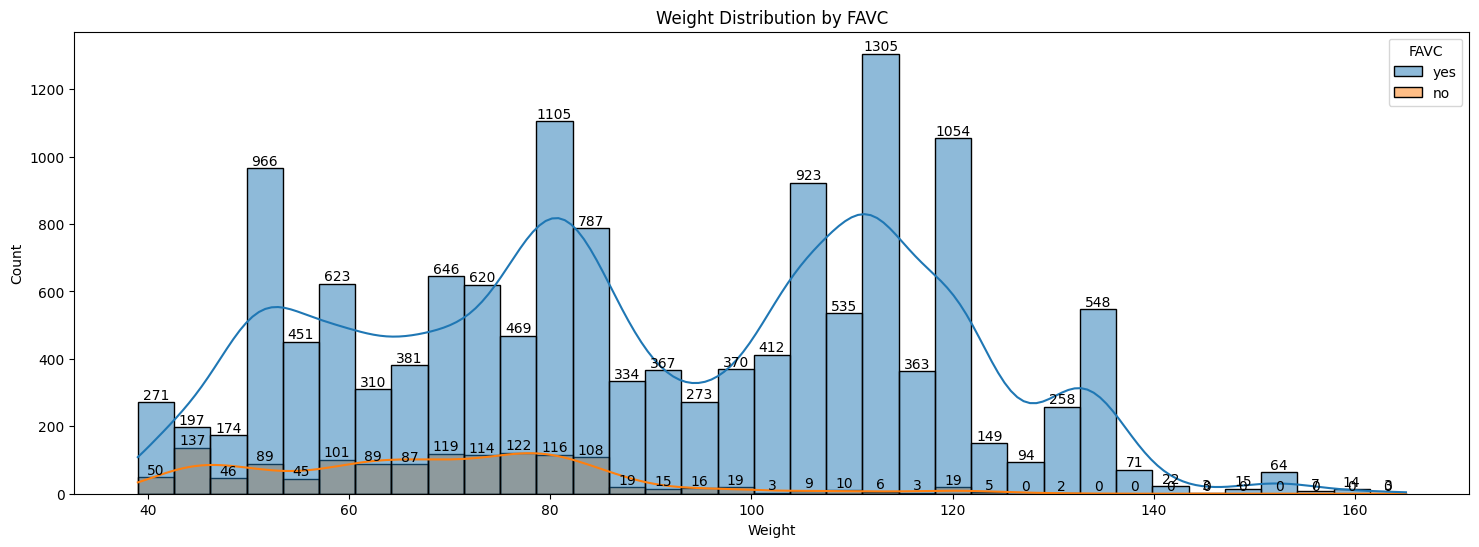

In [14]:
plt.figure(figsize=(18, 6))
ax = sns.histplot(data=train_df, x='Weight', hue='FAVC', kde=True)
add_data_labels(ax)
plt.title('Weight Distribution by FAVC')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

## Data Preprocessing

In [15]:
# ---------------------------------------------------------------
# STEP 3: Create the Preprocessing Pipeline (ColumnTransformer)
# ---------------------------------------------------------------

# This 'preprocessor' is for your features (X)
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), numerical_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_cols),
        ('binary', OrdinalEncoder(), binary_cols),
        ('ordinal_caec', OrdinalEncoder(categories=[caec_order], handle_unknown='use_encoded_value', unknown_value=-1), ['CAEC']),
        ('ordinal_calc', OrdinalEncoder(categories=[calc_order], handle_unknown='use_encoded_value', unknown_value=-1), ['CALC'])
    ],
    remainder='drop' # Drops any columns we didn't specify (like 'id')
)

# ---------------------------------------------------------------
# STEP 4: Apply the Pipeline to your Data
# ---------------------------------------------------------------

# Separate features (X) and target (y)
X_train = train_df.drop(columns=[target_col] + drop_cols, errors='ignore')
y_train = train_df[target_col]

# The test set from the competition might not have the target column
if target_col in test_df.columns:
    X_test = test_df.drop(columns=[target_col] + drop_cols, errors='ignore')
    y_test = test_df[target_col] # If you have a local validation set
else:
    X_test = test_df.drop(columns=drop_cols, errors='ignore')

# Fit the preprocessor on TRAINING data and transform BOTH
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ---------------------------------------------------------------
# STEP 5: Encode the Target Variable (y)
# ---------------------------------------------------------------
le2 = LabelEncoder()
y_train_encoded = le2.fit_transform(y_train)
feature_names = preprocessor.get_feature_names_out()

# Convert back to a DataFrame (optional, but good for inspection)
X_train_final = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_final = pd.DataFrame(X_test_processed, columns=feature_names)

print("Preprocessing Complete!")
print("Final training data shape:", X_train_final.shape)
print("Example feature names:", feature_names)

Preprocessing Complete!
Final training data shape: (15533, 17)
Example feature names: ['scale__Age' 'scale__BMI' 'scale__NCP' 'scale__CH2O' 'scale__FAF'
 'scale__TUE' 'onehot__MTRANS_Automobile' 'onehot__MTRANS_Bike'
 'onehot__MTRANS_Motorbike' 'onehot__MTRANS_Public_Transportation'
 'onehot__MTRANS_Walking' 'binary__Gender'
 'binary__family_history_with_overweight' 'binary__SCC' 'binary__SMOKE'
 'ordinal_caec__CAEC' 'ordinal_calc__CALC']


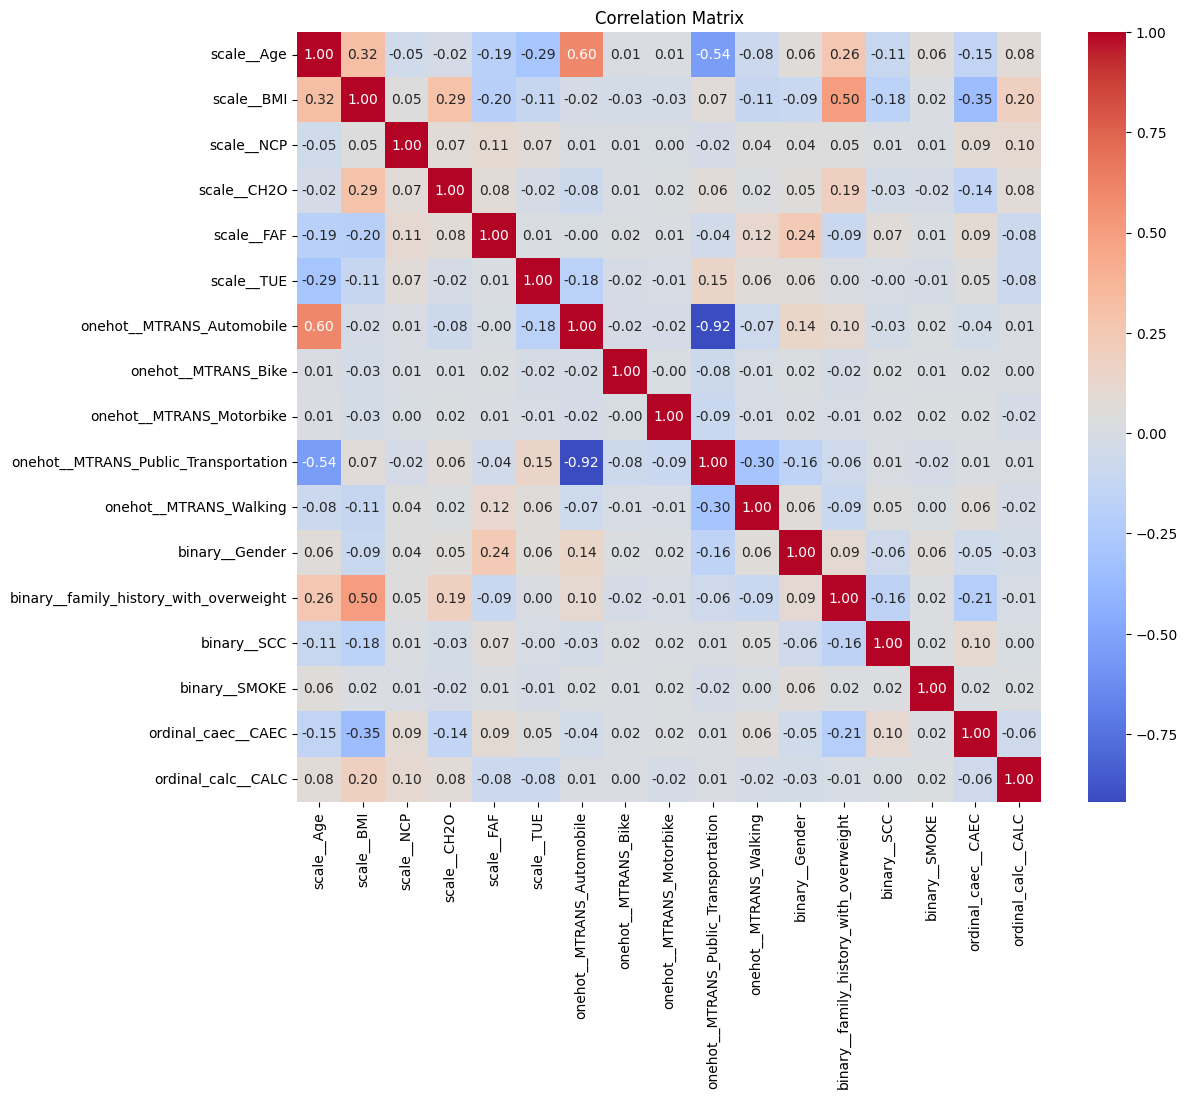

In [16]:
# lets visualize correlations
plt.figure(figsize=(12,10))
correlation_matrix = X_train_final.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [17]:
print(X_train_final.head())
print(X_test_final.head())

   scale__Age  scale__BMI  scale__NCP  scale__CH2O  scale__FAF  scale__TUE  \
0    0.110667   -0.235071    0.315486     1.211010   -1.167485    0.602221   
1   -1.027075   -0.816880    0.339130    -0.045459    0.027524    0.641290   
2   -1.027075   -1.574034   -1.909206    -0.192933   -0.132554    1.759822   
3   -0.505665    1.760978    0.339130    -0.581796    0.586624    0.276295   
4    1.381740   -0.555043   -1.116801    -0.078619    1.184260    0.527908   

   onehot__MTRANS_Automobile  onehot__MTRANS_Bike  onehot__MTRANS_Motorbike  \
0                        0.0                  0.0                       0.0   
1                        1.0                  0.0                       0.0   
2                        0.0                  0.0                       0.0   
3                        0.0                  0.0                       0.0   
4                        0.0                  0.0                       0.0   

   onehot__MTRANS_Public_Transportation  onehot__MTRANS_

## Model Definition and Train, Test Splits

In [18]:
XGB = XGBClassifier()

X_train, X_val, y_train, y_val = train_test_split(X_train_final, y_train_encoded, test_size=0.2, random_state=42)

In [19]:
# XGB.fit(X_train, y_train)

# # training accuracy
# y_train_pred = XGB.predict(X_train)
# print("Training Predictions:", y_train_pred)
# train_accuracy = accuracy_score(y_train, y_train_pred)
# print(f"Training Accuracy: {train_accuracy*100:.2f}%")

# #validation accuracy
# y_val_pred = XGB.predict(X_val)
# print("Validation Predictions:", y_val_pred)
# val_accuracy = accuracy_score(y_val, y_val_pred)
# print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

## HyperParameter Tuning

In [20]:
print("--- Tuning n_estimators and learning_rate ---")

param_grid_1 = {
    'learning_rate': [0.025, 0.05, 0.1, 0.2],
    'n_estimators': [400, 800, 1000, 1200]
}

grid_search_1 = GridSearchCV(estimator=XGB, param_grid=param_grid_1, 
                             scoring='accuracy', n_jobs=-1, cv=5, verbose=1)

grid_search_1.fit(X_train, y_train)

print("Best Parameters (Step 1):", grid_search_1.best_params_)
# Store the best parameters to use in the next steps
best_params = grid_search_1.best_params_

--- Tuning n_estimators and learning_rate ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits


Best Parameters (Step 1): {'learning_rate': 0.05, 'n_estimators': 400}


In [21]:
print("\n--- Tuning max_depth and min_child_weight ---")

# Update the classifier with the best parameters found so far
xgb_clf_2 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators']
)

param_grid_2 = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [3, 4, 5]
}

grid_search_2 = GridSearchCV(estimator=xgb_clf_2, param_grid=param_grid_2,
                             scoring='accuracy', n_jobs=-1, cv=5, verbose=1)

grid_search_2.fit(X_train, y_train)

print("Best Parameters (Step 2):", grid_search_2.best_params_)
# Update our best parameters dictionary
best_params.update(grid_search_2.best_params_)


--- Tuning max_depth and min_child_weight ---
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:16:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:16:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:16:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:16:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters (Step 2): {'max_depth': 5, 'min_child_weight': 5}


In [22]:
print("\n--- Tuning subsample and colsample_bytree ---")

xgb_clf_3 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    **best_params # Pass all best params found so far
)

param_grid_3 = {
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.9, 1.0]
}

grid_search_3 = GridSearchCV(estimator=xgb_clf_3, param_grid=param_grid_3,
                             scoring='accuracy', n_jobs=-1, cv=5, verbose=1)

grid_search_3.fit(X_train, y_train)

print("Best Parameters (Step 3):", grid_search_3.best_params_)
best_params.update(grid_search_3.best_params_)


--- Tuning subsample and colsample_bytree ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:16:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:16:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:16:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:16:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters (Step 3): {'colsample_bytree': 1.0, 'subsample': 0.8}


In [23]:
print("\n--- Tuning gamma and reg_lambda ---")

xgb_clf_4 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    **best_params
)

param_grid_4 = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
}

grid_search_4 = GridSearchCV(estimator=xgb_clf_4, param_grid=param_grid_4,
                             scoring='accuracy', n_jobs=-1, cv=5, verbose=1)

grid_search_4.fit(X_train, y_train)

print("Best Parameters (Step 4):", grid_search_4.best_params_)
best_params.update(grid_search_4.best_params_)


--- Tuning gamma and reg_lambda ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:16:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:16:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:16:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:16:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters (Step 4): {'gamma': 0}


## Final Model Training

In [24]:
# Create the final, tuned model
final_xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    **best_params
)

# Train on the full training data
final_xgb_clf.fit(X_train_final, y_train_encoded)

/home/vansh-doshi/scraping_JD/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:17:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [25]:
# # training accuracy
# y_train_pred = final_xgb_clf.predict(X_train)
# print("Training Predictions:", y_train_pred)
# train_accuracy = accuracy_score(y_train, y_train_pred)
# print(f"Training Accuracy: {train_accuracy*100:.2f}%")

# #validation accuracy
# y_val_pred = final_xgb_clf.predict(X_val)
# print("Validation Predictions:", y_val_pred)
# val_accuracy = accuracy_score(y_val, y_val_pred)
# print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

## Predictions and Making the Submission file for Kaggle Submission

In [26]:
# XGB.fit(X, y)
preds = final_xgb_clf.predict(X_test_final)

In [27]:
final_preds = le2.inverse_transform(preds)
print(final_preds)

['Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II' ...
 'Obesity_Type_I' 'Overweight_Level_II' 'Obesity_Type_II']


In [28]:
print(len(final_preds))
print(len(test_df['id']))

5225
5225


In [29]:
with open("submission.csv", "w") as f:
    f.write("id,WeightCategory\n")
    for i in range(len(final_preds)):
        f.write(f"{test_df['id'][i]},{final_preds[i]}\n")